In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import keras
import numpy as np

In [3]:
import zipfile
with zipfile.ZipFile("train-pawan.zip","r") as zip_ref:
    zip_ref.extractall(r"D:\Tomato detection")

In [5]:
import zipfile

In [8]:
def image_gen_w_aug(train_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range = 30,  
                                      zoom_range = 0.2, 
                                      width_shift_range=0.1,  
                                      height_shift_range=0.1,
                                      validation_split = 0.15)
    
  
    
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size = (75,75),
                                                       batch_size = 40,
                                                       class_mode = 'categorical',
                                                       subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                          target_size = (75,75),
                                                          batch_size = 7,
                                                          class_mode = 'categorical',
                                                          subset = 'validation')
    
    test_generator = test_datagen.flow_from_directory(train_parent_directory,
                                                     target_size=(75,75),
                                                     batch_size = 7,
                                                     class_mode = 'categorical')
    
    return train_generator, val_generator, test_generator


In [9]:
train_dir = os.path.join('train')

In [10]:
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir)

Found 347 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


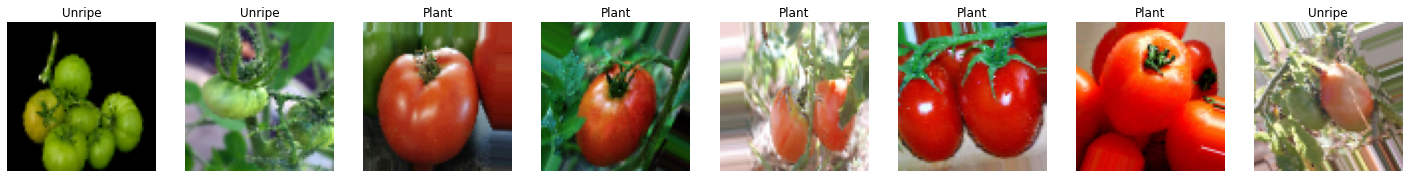

In [11]:
import numpy as np

CLASS_NAMES = np.array(['plant','unripe'], dtype='<U10')

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [12]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')

In [13]:
def model_output_for_TL (pre_trained_model, last_output):

    x = Flatten()(last_output)
    
    # Dense hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output neuron. 
    x = Dense(2, activation='softmax')(x)
    
    model = Model(pre_trained_model.input, x)
    
    return model

In [14]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed3')
last_output = last_layer.output

model_TL = model_output_for_TL(pre_trained_model, last_output)
model_TL.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model_TL.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
history_TL = model_TL.fit(
      train_generator,
      steps_per_epoch=5,  
      epochs=20,
      verbose=1,
      validation_data = validation_generator)

Epoch 1/20
5/5 [==============================] - 4s 518ms/step - loss: 12.4169 - accuracy: 0.5100 - val_loss: 10.0417 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 1s 287ms/step - loss: 5.2295 - accuracy: 0.4973 - val_loss: 4.9587 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 1s 284ms/step - loss: 3.1030 - accuracy: 0.5350 - val_loss: 2.2106 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 1s 258ms/step - loss: 2.1084 - accuracy: 0.5200 - val_loss: 0.9298 - val_accuracy: 0.5500
Epoch 5/20
5/5 [==============================] - 1s 264ms/step - loss: 1.1248 - accuracy: 0.5500 - val_loss: 0.6219 - val_accuracy: 0.6500
Epoch 6/20
5/5 [==============================] - 1s 252ms/step - loss: 0.8414 - accuracy: 0.6471 - val_loss: 0.6786 - val_accuracy: 0.6500
Epoch 7/20
5/5 [==============================] - 1s 249ms/step - loss: 0.6579 - accuracy: 0.6400 - val_loss: 0.6424 - val_accuracy: 0.6667
Epoch 8/20
5/5 [==

In [17]:
tf.keras.models.save_model(model_TL,'rps_model.hdf5')

,loss,accuracy,val_loss,val_accuracy
0,12.416869,0.510000,10.041651,0.500000
1,5.229539,0.497326,4.958712,0.500000
2,3.102983,0.535000,2.210550,0.500000
3,2.108431,0.520000,0.929770,0.550000
4,1.124801,0.550000,0.621913,0.650000
5,0.841437,0.647059,0.678597,0.650000
6,0.657870,0.640000,0.642417,0.666667
7,0.606995,0.668449,0.674470,0.633333
8,0.549554,0.720000,0.634257,0.633333
9,0.547407,0.727273,0.620971,0.683333


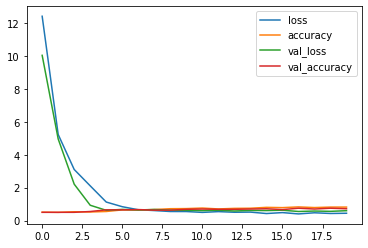

In [18]:
#Graphing
import pandas as pd
loss = pd.DataFrame(model_TL.history.history)
loss.plot()
loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


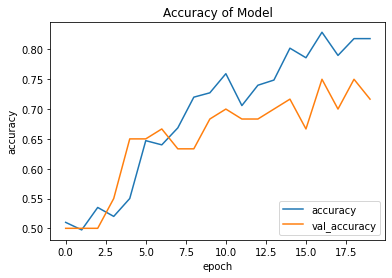

In [19]:
#Accuracy
import matplotlib.pyplot as plt
print(history_TL.history.keys())
plt.plot(history_TL.history['accuracy'])
plt.plot(history_TL.history['val_accuracy'])
plt.title('Accuracy of Model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc = 'lower right')
plt.show()

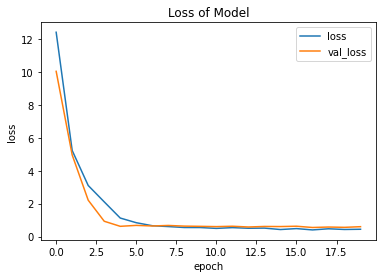

In [20]:
#Loss
plt.plot(history_TL.history['loss'])
plt.plot(history_TL.history['val_loss'])
plt.title('Loss of Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc = 'upper right')
plt.show()

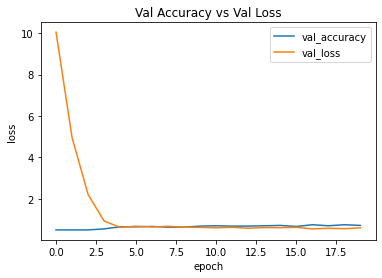

In [21]:
#Val accuracy vs Val Loss
plt.plot(history_TL.history['val_accuracy'])
plt.plot(history_TL.history['val_loss'])
plt.title('Val Accuracy vs Val Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_accuracy', 'val_loss'], loc = 'upper right')
plt.show()

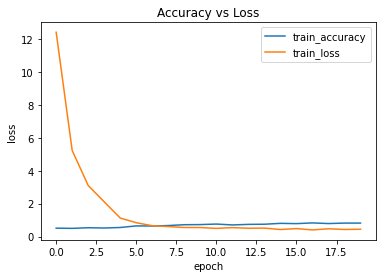

In [22]:
#Train accuracy vs Train Loss
plt.plot(history_TL.history['accuracy'])
plt.plot(history_TL.history['loss'])
plt.title('Accuracy vs Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_accuracy', 'train_loss'], loc = 'upper right')
plt.show()

In [23]:
#Using PIL
import PIL
import numpy as np
from matplotlib import pyplot
from PIL import Image, ImageOps
size = (75,75)
rps = np.array([1, 2, 3], dtype = '<U10')
url = input(" Please enter a url : ")
picture = Image.open(url)
pyplot.imshow(picture)
picture = ImageOps.fit(picture, size, Image.ANTIALIAS)
picture = picture.convert('RGB')
picture = np.asarray(picture)
picture = (picture.astype(np.float32) / 255.0)
picture_reshape = picture[np.newaxis,...]
y_pred = model_TL.predict(picture_reshape)
#y_pred = rps[y_pred[0]]
print(f'The predicted output is : {y_pred}')
if np.argmax(y_pred) == 0:
  print("It's a Plant")
elif np.argmax(y_pred) == 1:
  print("It's unripe")


KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install streamlit -q

     |████████████████████████████████| 9.1 MB 5.2 MB/s 
     |████████████████████████████████| 111 kB 34.0 MB/s 
     |████████████████████████████████| 178 kB 26.5 MB/s 
     |████████████████████████████████| 180 kB 48.2 MB/s 
     |████████████████████████████████| 4.3 MB 11.7 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 126 kB 55.4 MB/s 
     |████████████████████████████████| 791 kB 46.9 MB/s 
     |████████████████████████████████| 374 kB 57.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.6.0 which is incompatible.
google-colab 1.0.0 requires ipytho

In [28]:
%%writefile app.py
import numpy as np
import streamlit as st
import tensorflow as tf
from PIL import Image, ImageOps

def import_and_predict(image_data, model):
    
        size = (75,75)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = image.convert('RGB')
        image = np.asarray(image)
        image = (image.astype(np.float32) / 255.0)

        img_reshape = image[np.newaxis,...]

        prediction = model.predict(img_reshape)
        
        return prediction

model = tf.keras.models.load_model('rps_model.hdf5')

st.write("""
         # Ripe and Unripe Tomato Classifier
         """
         )

st.write("This is a simple image classification web app to predict whether a tomato is ripe or unripe")

file = st.file_uploader("Please upload an image file", type=["jpg", "png"])
#
if file is None:
    st.text("You haven't uploaded an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image, model)
    
    if np.argmax(prediction) == 0:
        st.write("It is Ripe!")
    elif np.argmax(prediction) == 1:
        st.write("It is Unripe!")
   
    
    st.text("Probability (0: Plant, 1: Unripe)")
    st.write(prediction)

Writing app.py


In [ ]:
!pip install pyngrok==4.1.1 --quiet

In [29]:
from pyngrok import ngrok

In [32]:
streamlit run app.py 

UsageError: Line magic function `%streamlit` not found.
